In [17]:
#######################################
# imports and initialization
#######################################

# For development purposes, reload imported modules when source changes
%load_ext autoreload
%autoreload 2

def append_to_path(dir0): # A convenience function
    if dir0 not in sys.path:
        sys.path.append(dir0)

# standard imports
import os, sys, json
import numpy as np
from matplotlib import pyplot as plt

# mountainlab imports
from mountainlab_pytools import mlproc as mlp
from mountainlab_pytools import mdaio
import spikeforestwidgets as SFW

# imports from this repo
append_to_path(os.getcwd()+'/../..')
from mountainsort4_1_0 import sort_dataset as ms4_sort_dataset # MountainSort spike sorting
from validate_sorting_results import validate_sorting_results # Validation processors
from default_lari_servers import default_lari_servers # Choices for processing servers
from synthesize_dataset import synthesize_dataset # Synthesize a test dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Define which Singularity containers we will use for the processing
# The name of the processor determines which container is used
mlp.setContainerRules([])
mlp.addContainerRule(pattern='ephys.*',container='shub://magland/ml_ephys:v0.2.5')
mlp.addContainerRule(pattern='ms4alg.*',container='shub://magland/ml_ms4alg:v0.1.4')
mlp.addContainerRule(pattern='pyms.*',container='shub://magland/ml_pyms:v0.0.1')
mlp.addContainerRule(pattern='ms3.*',container='shub://magland/ml_ms3:v0.0.2')

In [18]:
#######################################
# LARI login and initialize the pipeline object
#######################################

SFW.LariLoginWidget(default_lari_servers()).display()
Pipeline=mlp.initPipeline()

JSProxyWidget(status='Not yet rendered')

JSProxyWidget(status='Not yet rendered')

In [19]:
# Make synthetic ephys data and create output directory
dsdir=os.getcwd()+'/dataset'
with Pipeline:
    synthesize_dataset(dsdir,M=4,duration=600,average_snr=8)
    
output_base_dir=os.getcwd()+'/output'
if not os.path.exists(output_base_dir):
    os.mkdir(output_base_dir)

Output()

Finished pipeline.


In [15]:
## Note that the following does not work yet when using the local computer for computation
## because I have not yet exposed the file system to the javascript widget

#SFW.viewDataset(directory=dsdir)

In [16]:
#######################################
# RUN THE PIPELINE
#######################################
output_dir=output_base_dir+'/ms4'
with Pipeline:
    ms4_sort_dataset(dataset_dir=dsdir,output_dir=output_dir,adjacency_radius=-1,detect_threshold=3)
    A=validate_sorting_results(dataset_dir=dsdir,sorting_output_dir=output_dir,output_dir=output_dir)
    amplitudes_true=A['amplitudes_true']
    accuracies=A['accuracies']

Output()

Output()

Exception: Error running process ms4alg.create_label_map: Process returned with non-zero error code (255)

Text(0.5,1,'Accuracy vs. amplitude for simulated data')

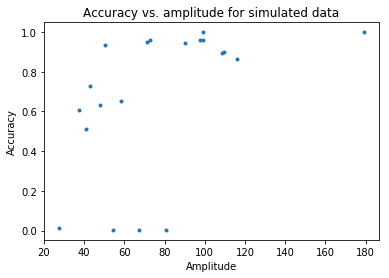

In [9]:
# Plot the comparison with ground truth
plt.plot(amplitudes_true,accuracies,'.')
plt.xlabel('Amplitude')
plt.ylabel('Accuracy');
plt.title('Accuracy vs. amplitude for {}'.format('simulated data'))